In [1]:
# 필요한 패키지 import
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split

# 입력된 데이터를 변환하기 위한 코드
# transforms는 여러 transform으로 구성될 수 있음 (리스트로 구성)
# PIL 이미지 혹은 numpy 배열(0 ~ 255의 값을 포함)을 torch tensor(0 ~ 1의 값을 포함)으로 변환
transform = transforms.Compose([transforms.ToTensor()])

# 배치 사이즈
batch_size = 256

# MNIST 데이터셋을 없는 경우 다운로드 (transform 적용)
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# 위에서 다운로드 받은 데이터셋을 배치 사이즈 단위로 샘플을 묶어 데이터 로더로 변환 (shuffle 과정 포함)
# shuffle을 통해 overfitting 방지 가능
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

100%|██████████| 9912422/9912422 [00:01<00:00, 7470124.73it/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 32828101.31it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 4957685.10it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 17887820.44it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



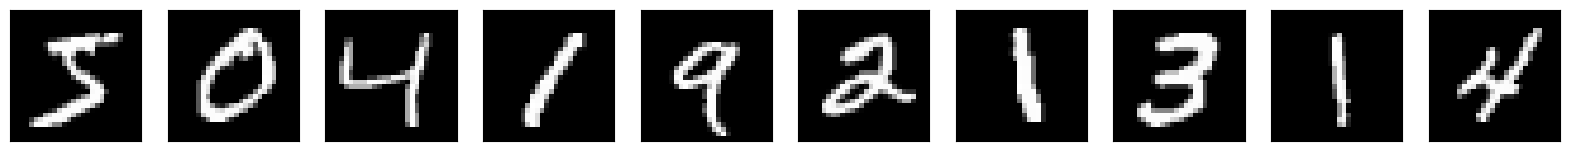

In [2]:
import numpy as np
import matplotlib.pyplot as plt

num_pictures = 10
plt.figure(figsize=(20, 5))

for i in range(num_pictures):
	# i번째 이미지
	img = trainset[i][0]
	
	# (1 x num_pictures) 행의 i번째에 이미지를 출력하기 위함
	ax = plt.subplot(1, num_pictures, i+1)

	# x, y 축 안보이게 설정
	ax.get_xaxis().set_visible(False)
	ax.get_yaxis().set_visible(False)

	plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')

plt.show()

In [3]:
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

layers = 8
kernel = 7
channel = 64

class MaskedCNN(nn.Conv2d):
	def __init__(self, mask_type, *args, **kwargs):
		self.mask_type = mask_type

		assert mask_type in ['A', 'B'], "Unknown Mask Type"

		# Mask
		#         -------------------------------------
		#        |  1       1       1       1       1 |
		#        |  1       1       1       1       1 |
		#        |  1       1    1 if B     0       0 |   H // 2
		#        |  0       0       0       0       0 |   H // 2 + 1
		#        |  0       0       0       0       0 |
		#         -------------------------------------
		#  index    0       1     W//2    W//2+1

		super(MaskedCNN, self).__init__(*args, **kwargs)
		
		# mask라는 이름의 buffer 생성
		self.register_buffer('mask', self.weight.data.clone())
		
		_, depth, height, width = self.weight.size()

		# mask를 1로 채움
		self.mask.fill_(1)

		if mask_type == 'A':
			self.mask[:, :, height//2, width//2:] = 0
			self.mask[:, :, height//2+1:, :] = 0

		elif mask_type == 'B':
			self.mask[:, :, height//2, width//2+1] = 0
			self.mask[:, :, height//2+1:, :] = 0

	def forward(self, x):
		# Convlution 연산 수행 이전에 마스크 적용
		self.weight.data *= self.mask
		return super(MaskedCNN, self).forward(x)


class PixelCNN(nn.Module):
	def __init__(self, no_layers=8, kernel=7, channels=64, device=None):
		super(PixelCNN, self).__init__()
		self.no_layers = no_layers
		self.kernel = kernel
		self.channels = channels
		self.layers = {}
		self.device = device

		self.MaskAConv = nn.Sequential(
			MaskedCNN(
				mask_type='A', 
				in_channels=1, 
				out_channels=channels, 
				kernel_size=kernel, 
				stride=1, 
				padding=kernel//2, 
				bias=False
			),
			nn.BatchNorm2d(channels),
			nn.ReLU(True)
		)

		MaskBConv = []
		for i in range(8):
			MaskBConv.append(MaskedCNN('B', channels, channels, kernel, 1, kernel//2, bias=False))
			MaskBConv.append(nn.BatchNorm2d(channels))
			MaskBConv.append(nn.ReLU(True))
		self.MaskBConv = nn.Sequential(*MaskBConv)
		self.out = nn.Conv2d(channels, 256, 1) # 0 ~ 255 logits

	def forward(self, x):
		x = self.MaskAConv(x)
		x = self.MaskBConv(x)
		return self.out(x) # (batch_size, 256, height, width)

model = PixelCNN().to(device)

print(model)

PixelCNN(
  (MaskAConv): Sequential(
    (0): MaskedCNN(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (MaskBConv): Sequential(
    (0): MaskedCNN(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaskedCNN(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaskedCNN(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): MaskedCNN(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (10): Batch

In [5]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=0.001)

criterion = nn.CrossEntropyLoss()

In [6]:
import math

no_images = 5
images_size = 28
images_channels = 1

def sampling():
	model.eval()
	sample = torch.Tensor(no_images, images_channels, images_size, images_size).to(device)
	sample.fill_(0) # Fill the tensor with 0

	# Generating images pixel by pixel
	for i in range(images_size):
		for j in range(images_size):
			out = model(sample)
			probs = F.softmax(out[:, :, i, j], dim=-1).data # 256 logit values per pixel
			
			# (i, j)번째에는 0값부터 255까지 나올 수 있는 확률들이 존재한다.
			# 255개의 확률 값들을 확률 분포로 해석하여 1개를 샘플링 한다.
			# 샘플링된 인덱스가 나오고 이것을 255를 max값으로 가정하고 정규화한다.
			sample[:, :, i, j] = torch.multinomial(input=probs, num_samples=1).float() / 255.0

	plt.figure(figsize=(10, 10))
	for i in range(no_images):
		ax = plt.subplot(1, no_images, i+1)
		ax.get_xaxis().set_visible(False)
		ax.get_yaxis().set_visible(False)
		plt.imshow(transforms.ToPILImage()(sample[i, :, :, :]), interplation="bicubic", cmap="gist_gray")
	plt.show()

In [7]:
from tqdm import tqdm

num_epochs = 100

for epoch in range(num_epochs):
	model.train()
	running_loss = 0.0

	# pbar 길이 : batch 갯수
	pbar = tqdm(enumerate(trainloader, 0), total=int(len(trainset) / trainloader.batch_size))

	for i, data in pbar:
		# input tensor : (batch_size, channels, height, width)
		inputs, _ = data
		target = (inputs[:, 0, :, :] * 255).long()
		
		inputs = inputs.to(device)
		target = target.to(device)

		optimizer.zero_grad()
		
		outputs = model(inputs)
		# outputs : (batch_size, 256, height, width) -> logits
		# target : (batch_size, 1, height, width) -> label
		loss = criterion(outputs, target)
		loss.backward()
		optimizer.step()

		running_loss += loss.item()
		pbar.set_description(f'epoch : {epoch + 1} of {num_epochs}, loss : {running_loss / (i+1):.3f}')

	sampling()

print('Training Finished')		

PATH = './savedModel.pth'
torch.save(model.state_dict(), PATH)

epoch : 1 of 100, loss : 5.620:   0%|          | 1/234 [01:00<3:54:45, 60.45s/it]